**Author:** Carolina Gonçalves, carolina.goncalves@research.fchampalimaud.org

**Scope**: The purpose of this notebook is to give an intuition about what are embeddings and what they mean to represent.

**Introduction**

> Language is a very rich form of conveying meaning. It allows to represent complex objects, entities and concepts of the world and human knowledge into simpler forms, such as words or sentences. Single words can aggregate multiple entities into a singular representation, by considering relevant properties shared between them (e.g: birds, trees, pets,...). Sentences can connect different words together, composing them into more complex entities or altering their meanings.

> Machine learning models trained on large corpora of text can learn these nuances and syntax of natural language, by analysing the contexts in which words appear. With this, they can learn the different relations between words and use these as a proxy to learn conceptual meaning: by learning the main properties (dimensions) within language that can relate certain terms and differentiate others, depending on the context. Different semantic meanings will have different properties, therefore one can build representations of meaning with these dimensions. These representations are what we call **embeddings**. Don't worry about the details now, we'll dive into that later.

> The most popular models are based on the Transformer architecture. These models learn embeddings by analyzing and predicting words based on their surrounding context during training, adjusting the vectors to minimize a loss function that encourages similar contexts to have similar vector representations.

We'll use two of these models in this notebook to show how we can generate embeddings and what they look like.

In [1]:
!pip install -U sentence-transformers
!pip install --upgrade gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import torch
import gensim.downloader as api #import Word2Vec model
from sentence_transformers import SentenceTransformer, util #import and sentence-transformer model

# libraries for visualization and plotting
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

### Plotting functions

(you can ignore this)

In [4]:
def plot_transition_matrix(scores_matrix, labels,
                title='Similarity Matrix',
                cmap=plt.cm.Blues):
    """
    This function prints and plots a confusion matrix.
    """
    plt.figure(figsize=(10, 10), dpi=100)

    im = plt.imshow(scores_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=8)

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = scores_matrix.max() / 2.
    for i, j in itertools.product(range(scores_matrix.shape[0]), range(scores_matrix.shape[1])):
        plt.text(j, i, round(scores_matrix[i, j],2),
                 horizontalalignment="center",
                 color="white" if scores_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.ylabel('Word')
    #plt.xlabel('Word')

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [5]:
def TSNE_embeddings(embeddings, labels):
  '''
  t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality
  reduction technique used to visualize high-dimensional data in 2D or 3D.
  It works by preserving the local structure of the data, ensuring that points
  that are close in the original high-dimensional space remain close in
  the lower-dimensional space.

  Perplexity controls the balance between local and global structure in the data
  by influencing how many nearby points are considered neighbors for each target vector.
  A lower perplexity focuses more on local relationships, while a higher perplexity
  considers a broader neighborhood, impacting how clusters are formed in the low-dimensional visualization.
  (requires tunning on the dataset)
  '''
  E = TSNE(n_components=2, perplexity=4, random_state=42).fit_transform(embeddings.detach().cpu())

  fig = plt.figure(figsize=(5,5))
  plt.scatter(E[:,0], E[:,1])
  for i, txt in enumerate(labels):
    plt.annotate(txt, (E[i,0] + 0.01, E[i,1] + 0.02))
  plt.grid(False)
  plt.xlabel("Embedding dimension 1")
  plt.ylabel("Embedding dimension 2")
  plt.title("Reduced Embedding space", fontsize=10)

## To be aware of:
# t-SNE is not deterministic and its iterative in its optimization process. Due to
# the latter's random nature and also the need to tune hyperparameters (like perplexity),
# different runs can lead to different outcomes and it can sometimes give an innacurate
# representation of the global structure and relationships between clusters.
# Therefore, interpreting t-SNE results requires caution, and it's often recommended
# to run t-SNE multiple times with different parameters to ensure consistent and reliable patterns.

# Word2Vec

Word2Vec is a popular NLP technique for obtaining vector representations of words. It uses a neural network model to learn embeddings of words based on their context in a large corpus of text. The embeddings can be computed in two main ways [[1]](https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673):
* model predicts a target word based on the surrounding context words (*Continuous Bag of Words* (CBOW));
* model predicts context surrounding words given a target word (*Skip-Gram*).

By iterating over a large corpus of text, the model adjusts the vectors so that words appearing in similar contexts end up with similar embeddings, capturing semantic relationships like synonyms and analogies within the vector space.


We'll use a pre-trained Word2Vec model from [Gensim](https://radimrehurek.com/gensim/intro.html), a free open-source Python library for representing documents as semantic vectors, as efficiently (computer-wise) and painlessly (human-wise) as possible.

In [6]:
# loading the model from gensim
wv = api.load('word2vec-google-news-300') #https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Intuitions behind embeddings

As mentioned before, word embeddings are semantic representations that were learned by the model as dense vector representations with N dimensions. Each word will have its own learned vector and this can be seen as a numerical representation, where each value tells how much of a specific property is present in this word.

I think the following image represents well enough the idea. It's important to note that we don't actually know which property each of the vector dimensions is representing. This is just an example to visualize the idea behind embeddings:

![Word embeddings](https://miro.medium.com/v2/resize:fit:4800/format:webp/0*OJ7EMq9Wcyqmak4F.png)

(taken from [[2]](https://medium.com/@amirhossein.abaskohi/word-embedding-a81e65faf3df))

In [7]:
# compute and print embeddings for different words
cat_embedding = torch.tensor(wv["cat"], dtype=torch.float32)
print(cat_embedding)
print(cat_embedding.shape)

mouse_embedding = torch.tensor(wv["mouse"], dtype=torch.float32)
print(mouse_embedding)
print(f"The model is computing embbedings with N={mouse_embedding.shape[0]} dimensions")

tensor([ 0.0123,  0.2041, -0.2852,  0.2168,  0.1182,  0.0830,  0.0498, -0.0095,
         0.2207, -0.1260,  0.0806, -0.5859, -0.0045, -0.2969, -0.0131, -0.0835,
         0.0505,  0.1514, -0.4492, -0.0135,  0.2148, -0.1475,  0.2246, -0.1250,
        -0.0972,  0.2490, -0.2891,  0.3652,  0.4121, -0.0859, -0.0786, -0.1973,
        -0.0908, -0.1416, -0.1025,  0.1309, -0.0035,  0.0723,  0.0442,  0.3457,
         0.0747, -0.1123,  0.0674,  0.1123,  0.0198, -0.1235,  0.2100, -0.0723,
        -0.0278,  0.0554, -0.3340,  0.0854,  0.3438,  0.1396,  0.0493, -0.1348,
         0.1631, -0.3730,  0.3965,  0.1069,  0.2217,  0.2129, -0.0898,  0.2070,
         0.0894, -0.0825,  0.0596,  0.1021, -0.1924, -0.0908,  0.4922,  0.0396,
        -0.0708, -0.0020, -0.2305,  0.2559,  0.0898, -0.1064,  0.0011, -0.0588,
         0.0510, -0.0292,  0.1934, -0.1416, -0.3340,  0.0815, -0.2754,  0.1006,
        -0.1045, -0.1235, -0.1406,  0.0349, -0.1177, -0.1797, -0.2148, -0.2383,
         0.0845, -0.0752, -0.2598, -0.21

 These are not only a sequences of numbers. Vectors represent points in space, their positions and orientations relative to the origin of the space. Models like Word2Vec learn to represent words in some sort of *conceptual space*, where each property is an axis/dimension and its value defines where along that axis the word should be represented. In this space, **words with similar meanings or usage patterns are positioned closer together**, enabling the model to recognize semantic relationships between them.

 ![Embeddings space](https://miro.medium.com/v2/resize:fit:640/format:webp/1*FlRTXg3GA8vVoIsLvsBr2Q.png)

 (taken from [[3]](https://towardsdatascience.com/word-embeddings-intuition-behind-the-vector-representation-of-the-words-7e4eb2410bba))

 In this way, we compute the semantic similarity between words by calculating how close or aligned their to embedding vectors are. A commonly used measure for this is *cosine similarity*, which measures the angle between two vectors.
* cosine similarity = 1: angle is 0, vectors are perfectly aligned.
* cosine similarity = 1: vectors are prependicular to each other.
* osine similarity = -1: vectors are pointing in completely opposite directions.

 ![Cosine similarity-intuition](https://miro.medium.com/v2/resize:fit:915/1*dyH20eCqb6qTL-gt4nCVzQ.png)

## Time to play

Let's take a set of words, compute the embeddings and try to see if we can spot patterns of meaning within these.

What do you see?



torch.Size([16, 300])


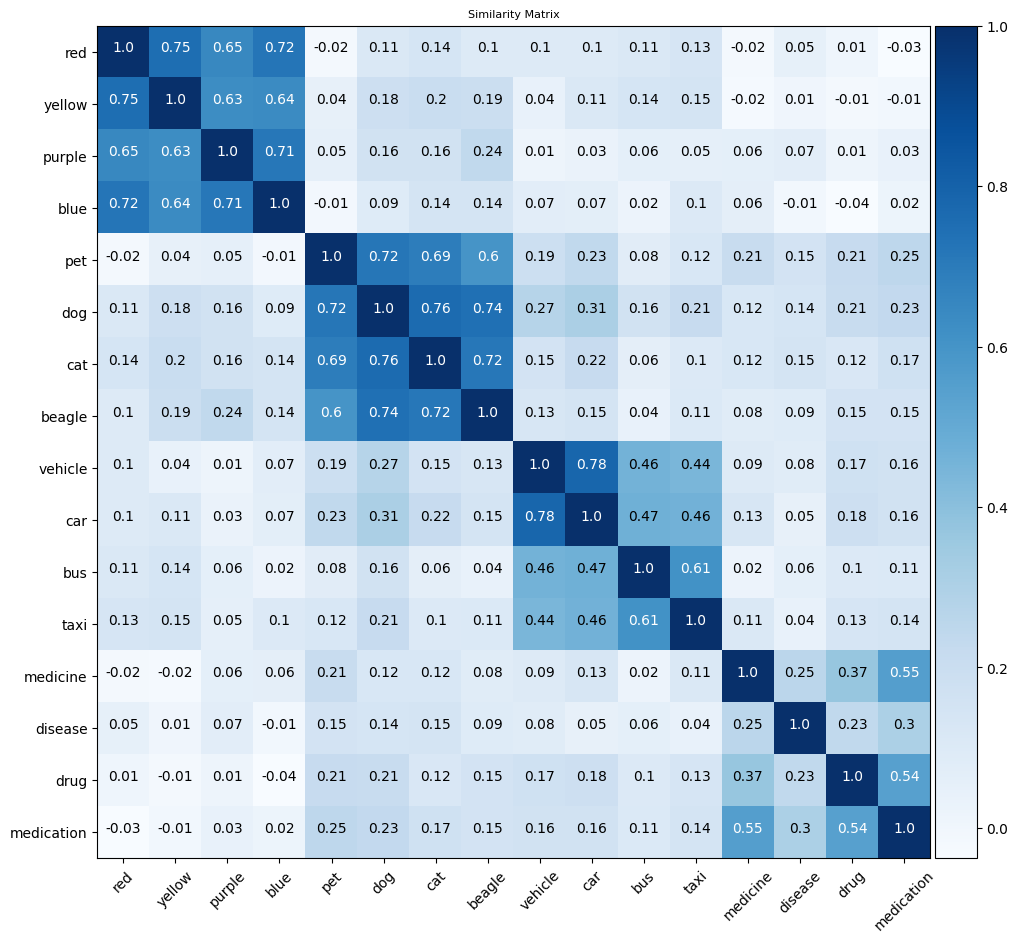

In [8]:
# A dummy dataset to explore how these models represent words and their relations
dummy_data = [
    "red", "yellow", "purple", "blue",
    "pet", "dog", "cat", "beagle",
    'vehicle', 'car', 'bus', 'taxi',
    "medicine", "disease", "drug", "medication"
]

# Compute the embedding for each word in dummy_data, using Word2Vec
embeddings = []
for word in dummy_data:
  embeddings.append(torch.tensor(wv[word], dtype=torch.float32).unsqueeze(0))
embeddings_wv = torch.cat(embeddings, dim=0)
print(embeddings_wv.shape)

# Compute the (cosine) similarity between each pair of embedding vectors
cos_similarity_wv = util.cos_sim(embeddings_wv, embeddings_wv)

# Plot these as a matrix of word similarity
plot_transition_matrix(cos_similarity_wv.numpy(), dummy_data)

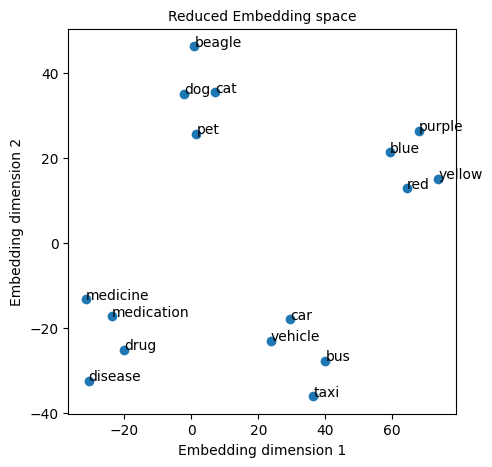

In [9]:
# We can also use a dimensionality reduction technique to plot a 2D representation of our emebddings and analyse
# possible clusters/groups of words. Here we use t-SNE as a tool to understand our high-dimensional space.
TSNE_embeddings(embeddings_wv, dummy_data)

In [10]:
# Word2Vec can also be used to find the most similar words to a specifc term
wv.most_similar("contract")

[('contracts', 0.7733357548713684),
 ('con_tract', 0.6541458964347839),
 ('multiyear_contract', 0.6522576808929443),
 ('Contract', 0.6450039148330688),
 ('conract', 0.6257626414299011),
 ('agreement', 0.5878522992134094),
 ('contractual', 0.5872957706451416),
 ('deal', 0.58133465051651),
 ('subcontract', 0.5560057163238525),
 ('Contracts', 0.5528260469436646)]

In [11]:
wv.most_similar("case")

[('cases', 0.6759247779846191),
 ('habeas_corpus_proceeding', 0.5479808449745178),
 ('Cases', 0.5464273691177368),
 ('prosecution', 0.5217494368553162),
 ('acquital', 0.521645188331604),
 ('Chanins', 0.520306408405304),
 ('recusal_motion', 0.5107461810112),
 ('trial', 0.5062978863716125),
 ('Judge_recuses_himself', 0.5034319758415222),
 ('prosection', 0.4952777624130249)]

In [12]:
wv.most_similar("woman")

[('man', 0.7664012908935547),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336829304695129),
 ('teenager', 0.6317085027694702),
 ('lady', 0.6288785934448242),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.6076306104660034),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975907444953918),
 ('Woman', 0.5770983099937439)]

In [13]:
wv.most_similar("women")

[('men', 0.767493724822998),
 ('Women', 0.7283449769020081),
 ('womens', 0.6786180734634399),
 ('girls', 0.6339040398597717),
 ('females', 0.6240420341491699),
 ('mothers', 0.6050933599472046),
 ('ladies', 0.5865179300308228),
 ('husbands', 0.5705342292785645),
 ('transwomen', 0.5697940587997437),
 ('Men', 0.5693342089653015)]

**Question**: Can you think of possible applications of this kind of model for search engines?

**Question**: For which situations can Word2Vec fail or not be good enough?

# Example in Portuguese

Let's try now a different embedding model and a different language.

In [14]:
pt_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
print(pt_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)


In [22]:
def embed_words(words, model):
  # Create embeddings for each word
  word_embeddings = []
  outputs = model.encode(words, convert_to_tensor=True)
  print(len(outputs))
  word_embeddings.append(outputs)

  # Concatenate the embeddings
  embeddings = torch.cat(word_embeddings, dim=0)
  print(embeddings.shape)
  return embeddings

16
torch.Size([16, 512])


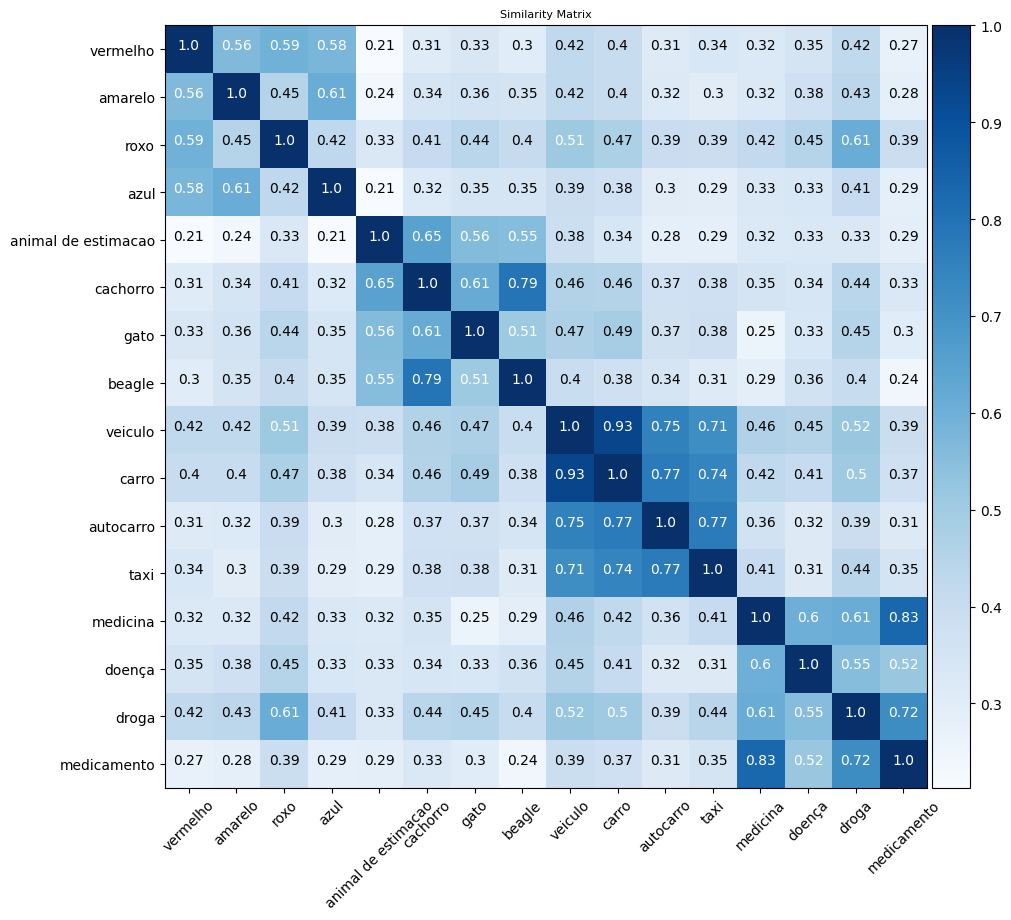

In [28]:
dummy_data_pt = [
    "vermelho", "amarelo", "roxo", "azul",
    "animal de estimacao", "cachorro", "gato", "beagle",
    "veiculo", "carro", "autocarro", "taxi",
    "medicina", "doença", "droga", "medicamento"
]

embeddings_pt = embed_words(dummy_data_pt, pt_model)

cos_similarity_pt = util.cos_sim(embeddings_pt, embeddings_pt)

if embeddings_pt.device.type == 'cuda':
  plot_transition_matrix(cos_similarity_pt.cpu().numpy(), dummy_data_pt)
else:
  plot_transition_matrix(cos_similarity_pt.numpy(), dummy_data_pt)

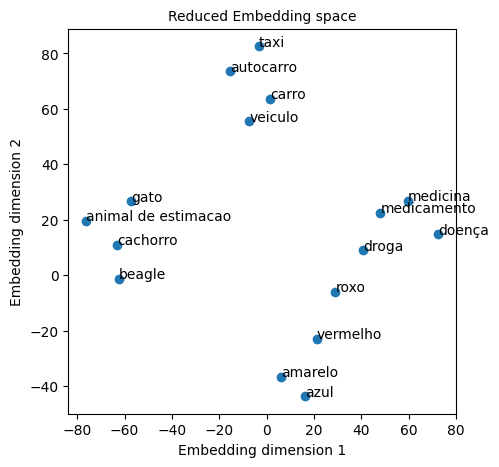

In [30]:
TSNE_embeddings(embeddings_pt, dummy_data_pt)

**Question**: The dataset used here is the translation of the one used for Word2Vec. Do you see any differences between the embeddings' similarities/associations produced in both cases? If so, can you reason about why these might happen?

# Beyond words

Thinking about words is probably the simplest way to understand the intuition behing embeddings. But, embeddings can represent also phrases, sentences or even entire documents, where each element of the vector captures some aspect of the meaning or context of the item it represents.

There are models trained to encode sentences or documents, such as Doc2Vec, Sentence Transformer models, ...